# Data_Profiling

                                                                              Team 1
                                                                              Gagan Karina

## Index
- [1. Objective](#1.-Objective)
- [2. Dataset](#2.-Dataset)
- [3. Importance of Data Profiling](#3.-Importance-of-Data-Profiling)
- [4. Enhancement of Data Dictionary](#4.-Enhancement-of-Data-Dictionary)
- [5. Installing AWS & Boto](#5.-Installing)
- [6. Importing Libraries](#6.-Importing-Libraries)

- [7. IAM User and S3 Bucket](#7.-IAM-User-and-S3-Bucket)
- [8. Uploading large files to S3](#8.-Uploading-large-files-to-S3)
    - [8.1 UDF to upload Large Dataset to S3 bucket ](#8.1-UDF-to-upload-Large-Dataset-to-S3-bucket)
    - [8.2 UDF to upload Small Dataset to S3 bucket](#8.2-UDF-to-upload-Small-Dataset-to-S3-bucket)
- [9. UDF to Load Dataset from S3 bucket to Pandas dataframe ](#9.-UDF-to-Load-Dataset-from-S3-bucket-to-Pandas-dataframe)
- [10. Dataset Profiling](#10.-Dataset-Profiling)
    - [Df head](#Df-head)
    - [Df Info](#Df-Info)
    - [Df Shape](#Df-Shape)
    - [Determine the category of each column in a DataFrame.](#Determine-the-category-of-each-column-in-a-DataFrame.)
    - [Statistical summary ](#Statistical-summary )
    - [Finding Null Rate](#Finding-Null-Rate)
    - [Categorical num unique values and most populous value for categorical](#Categorical-num-unique-values-and-most-populous-value-for-categorical)
    - [Numeric mean and std deviation](#Numeric-mean-and-std-deviation)
    - [Numerical Columns Visualisation](#Numerical-Columns-Visualisation)
    - [Categorical Columns Visualisation](#Categorical-Columns-Visualisation)
- [11. Performing data profiling using pandas_profiling library](#11.-Performing-data-profiling-using-pandas_profiling-library)
- [12. Import dataset into RDS](#12.-Import-dataset-into-RDS)

-----------------




### 1. Objective
In this assingmnet our main objective is to analyze a specific dataset, which is often an overlooked but crucial step in any data related project. By gaining an understanding of the datasets content and structure we can formulate meaningful questions streamline the development of Extract, Transform, Load (ETL) processes and improve our ability to adapt to changes.

### 2. Dataset
The dataset we will be using is the 2021 Yellow Taxi Trip Data from New York City. This dataset is publicly available through NYC Open Data. Due to its size and complexity we might choose to initially analyze a representative sample or use techniques suitable for analyzing large scale data.

### 3. Importance of Data Profiling
Data profiling plays a role even when we receive detailed information from data services, like NYC Open Data. It helps us validate the datas accuracy identify issues and grasp the intricacies that may not be fully explained in the provided data dictionary.

### 4. Enhancement of Data Dictionary
As part of this exercise our aim is to enhance the existing data dictionary provided by NYC Open Data for the 2021 Yellow Taxi Trip Data. This will enable us to enhance our comprehension of the dataset and guarantee that we have all the necessary tools to utilize the data efficiently.

------

### 5. Installing:
    - awscli
    - boto3

In [144]:
# Installing AWS cli 
##!pip install awscli

# Checking aws cli version
##!aws --version

# Installing boto3
##!pip install boto3

# Indtalling PyMySql
##pip install PyMySQL

### 6. Importing Libraries

In [145]:
# Importing the required libraries
import pandas as pd  # Importing the pandas library for data manipulation and analysis
import pandas_profiling  # Importing the pandas_profiling library for generating data profiling reports
import requests  # Importing the requests library for making HTTP requests
import boto3  # Importing the boto3 library for interacting with AWS services
from sqlalchemy import create_engine # Importing the create_engine function from the sqlalchemy library for database interaction
import configparser  # Importing the configparser library for reading configuration files
import warnings  # Importing the warnings module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warning messages
from botocore.exceptions import NoCredentialsError  # Importing the NoCredentialsError exception from the botocore library
import seaborn as sns # Importing the seaborn library for data visualisation
import matplotlib.pyplot as plt  # Importing the matplotlib library for data visualisation
plt.style.use(['seaborn-darkgrid']) # Applying darkgrid
import json # Importing jason library to ready the jason file

In [146]:
def import_libraries():
    """
    Function to import the required libraries for data analysis and visualization.
    """
    # Importing pandas for data manipulation and analysis
    import pandas as pd
    
    # Importing pandas_profiling for generating data profiling reports
    import pandas_profiling
    
    # Importing requests for making HTTP requests
    import requests
    
    # Importing boto3 for interacting with AWS services
    import boto3
    
    # Importing create_engine function from sqlalchemy for database interaction
    from sqlalchemy import create_engine
    
    # Importing configparser for reading configuration files
    import configparser
    
    # Importing warnings for handling warnings
    import warnings
    
    # Importing NoCredentialsError exception from botocore for handling AWS credentials error
    from botocore.exceptions import NoCredentialsError
    
    # Importing seaborn for data visualization
    import seaborn as sns
    
    # Importing matplotlib for data visualization
    import matplotlib.pyplot as plt
    
    # Importing json for reading JSON files
    import json
    
    # Ignore warning messages
    warnings.filterwarnings("ignore")
    
    # Applying seaborn darkgrid style
    plt.style.use(['seaborn-darkgrid'])
    
    print("Libraries imported successfully.")

# Calling the function to import the libraries
#import_libraries()

### 7. IAM User and S3 Bucket

- Created IAM user with CLI access as **'datapro'**, saved access key and secret key on local ~/aws/credentials.
- Created S3 Bucket **'datalz1'**.

In [147]:
## Checking Bucket list by 
session = boto3.Session(profile_name='datapro')
s3 = session.client('s3')
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]
print(buckets)

['datalz1', 'gluejoblab', 'info-arch-gaganpreetssingh-assignment-8a', 'infoarch-lab03-group1', 'teachbackdemobucket']


--------

### 8. Uploading large files to S3
- The dataset I have choosen for this assingment has 30.9M rows which is around 3Gb CSV file. 
- Yellow taxi Data API: https://data.cityofnewyork.us/Transportation/2021-Yellow-Taxi-Trip-Data/m6nq-qud6

##### Issue: 
- Uploading large files to S3 is problematic due to network issues, timeouts, or the limitations of certain systems.

##### Workaround:
1. __Increase the AWS S3 multipart upload threshold and chunksize:__
    - Using AWS SDKs which used Multipart upload for larger files
    - We can adjest the threshold as well as the chunk size to allow large parts of the of the file to be uploaded at once. 
    
    
2. __Use AWS CLI to upload the file:__
    - AWS CLI uses multipart upload automaticlly for the large files. 
    - aws s3 cp */path/to/your/file* *s3://yourbucket/your-key* --profile *profile_name*
    
    
3. __Use API to download the data in chunks and upload to s3:__
    - We can use API provided by NYC Open data source, to uto download the data in chunks and upload each chunk to S3 uisng Python.
    - We can use Python requests library to download the data and pandas to handle the chunks.
    - Assuming API will support the __limit__ and __offset__ parameters for this to work.
    - Python script breakdown:- 
        - The script will calculates the total number of records in the data source
        - It will download the data in chunks of 10,000 records
        - Then the downloaded data will converts each chunk to a pandas DataFrame & converts the DataFrame to a CSV string
        - once chunck will be cnverted to uploads the CSV data to S3 as a new file. Each file is named with the chunk number to distinguish it from the other files.
        - Also adding error handling to improve its robustness

-------

### 8.1 UDF to upload Large Dataset to S3 bucket

In [8]:
# UDF to upload Large-Dataset to S3 bucket 

def download_upload_data_S3(url, bucket, s3_file, profile_name, chunk_size):
    """
    Downloads data from a given URL in chunks, converts it to CSV format,
    and uploads each chunk to an S3 bucket using the specified profile name.

    Args:
        url (str): The URL to download the data from.
        bucket (str): The name of the S3 bucket to upload the data to.
        s3_file (str): The name of the S3 file to be created (without the chunk number).
        profile_name (str): The name of the AWS profile to use for authentication.
        chunk_size (int): The number of records to download and upload in each chunk.
    """
    # Creating a session with the specified profile name
    session = boto3.Session(profile_name=profile_name)

    # Creating an S3 resource using the session
    s3 = session.resource('s3')

    try:
        # Get the total number of records
        response = requests.get(url + "?$select=count(*)")
        response.raise_for_status()  # Raise an exception if the request was unsuccessful
        total_records = response.json()[0]['count']

        # Calculating the number of chunks
        num_chunks = int(total_records) // chunk_size + 1

        # Looping through the chunks
        for i in range(num_chunks):
            offset = i * chunk_size
            print(f"Processing chunk {i+1} of {num_chunks}, records {offset} to {offset + chunk_size}")

            # Getting the data for this chunk
            response = requests.get(url + f"?$limit={chunk_size}&$offset={offset}")
            response.raise_for_status()  # Raise an exception if the request was unsuccessful
            data = response.json()

            # Converting the data to a pandas DataFrame
            df = pd.DataFrame(data)

            # Converting the DataFrame to CSV and upload to S3
            csv_buffer = StringIO()
            df.to_csv(csv_buffer, index=False)
            s3.Object(bucket, f'{s3_file}_{i+1}.csv').put(Body=csv_buffer.getvalue())

        print("Upload Complete")

    except requests.exceptions.RequestException as e:
        print(f"Request to API failed: {e}")
    except boto3.exceptions.S3UploadFailedError as e:
        print(f"Upload to S3 failed: {e}")

In [9]:
url = "https://data.cityofnewyork.us/resource/m6nq-qud6.json"
bucket = 'datalz1'
s3_file = 'Yellow_Taxi_Trip_Data'
profile_name = 'datapro'
chunk_size = 10000

download_upload_data_S3(url, bucket, s3_file, profile_name, chunk_size)

Processing chunk 1 of 3091, records 0 to 10000
Processing chunk 2 of 3091, records 10000 to 20000
Processing chunk 3 of 3091, records 20000 to 30000
Processing chunk 4 of 3091, records 30000 to 40000
Processing chunk 5 of 3091, records 40000 to 50000
Processing chunk 6 of 3091, records 50000 to 60000
Processing chunk 7 of 3091, records 60000 to 70000
Processing chunk 8 of 3091, records 70000 to 80000
Processing chunk 9 of 3091, records 80000 to 90000
Processing chunk 10 of 3091, records 90000 to 100000
Processing chunk 11 of 3091, records 100000 to 110000
Processing chunk 12 of 3091, records 110000 to 120000
Processing chunk 13 of 3091, records 120000 to 130000
Processing chunk 14 of 3091, records 130000 to 140000
Processing chunk 15 of 3091, records 140000 to 150000
Processing chunk 16 of 3091, records 150000 to 160000
Processing chunk 17 of 3091, records 160000 to 170000
Processing chunk 18 of 3091, records 170000 to 180000
Processing chunk 19 of 3091, records 180000 to 190000
Proces

KeyboardInterrupt: 

- Above download_upload_data_S3 is stopped manually, it was just for testing. 
- Data in chuncks are uploading to the s3 bucket - *datalz1*

- Screen Shot
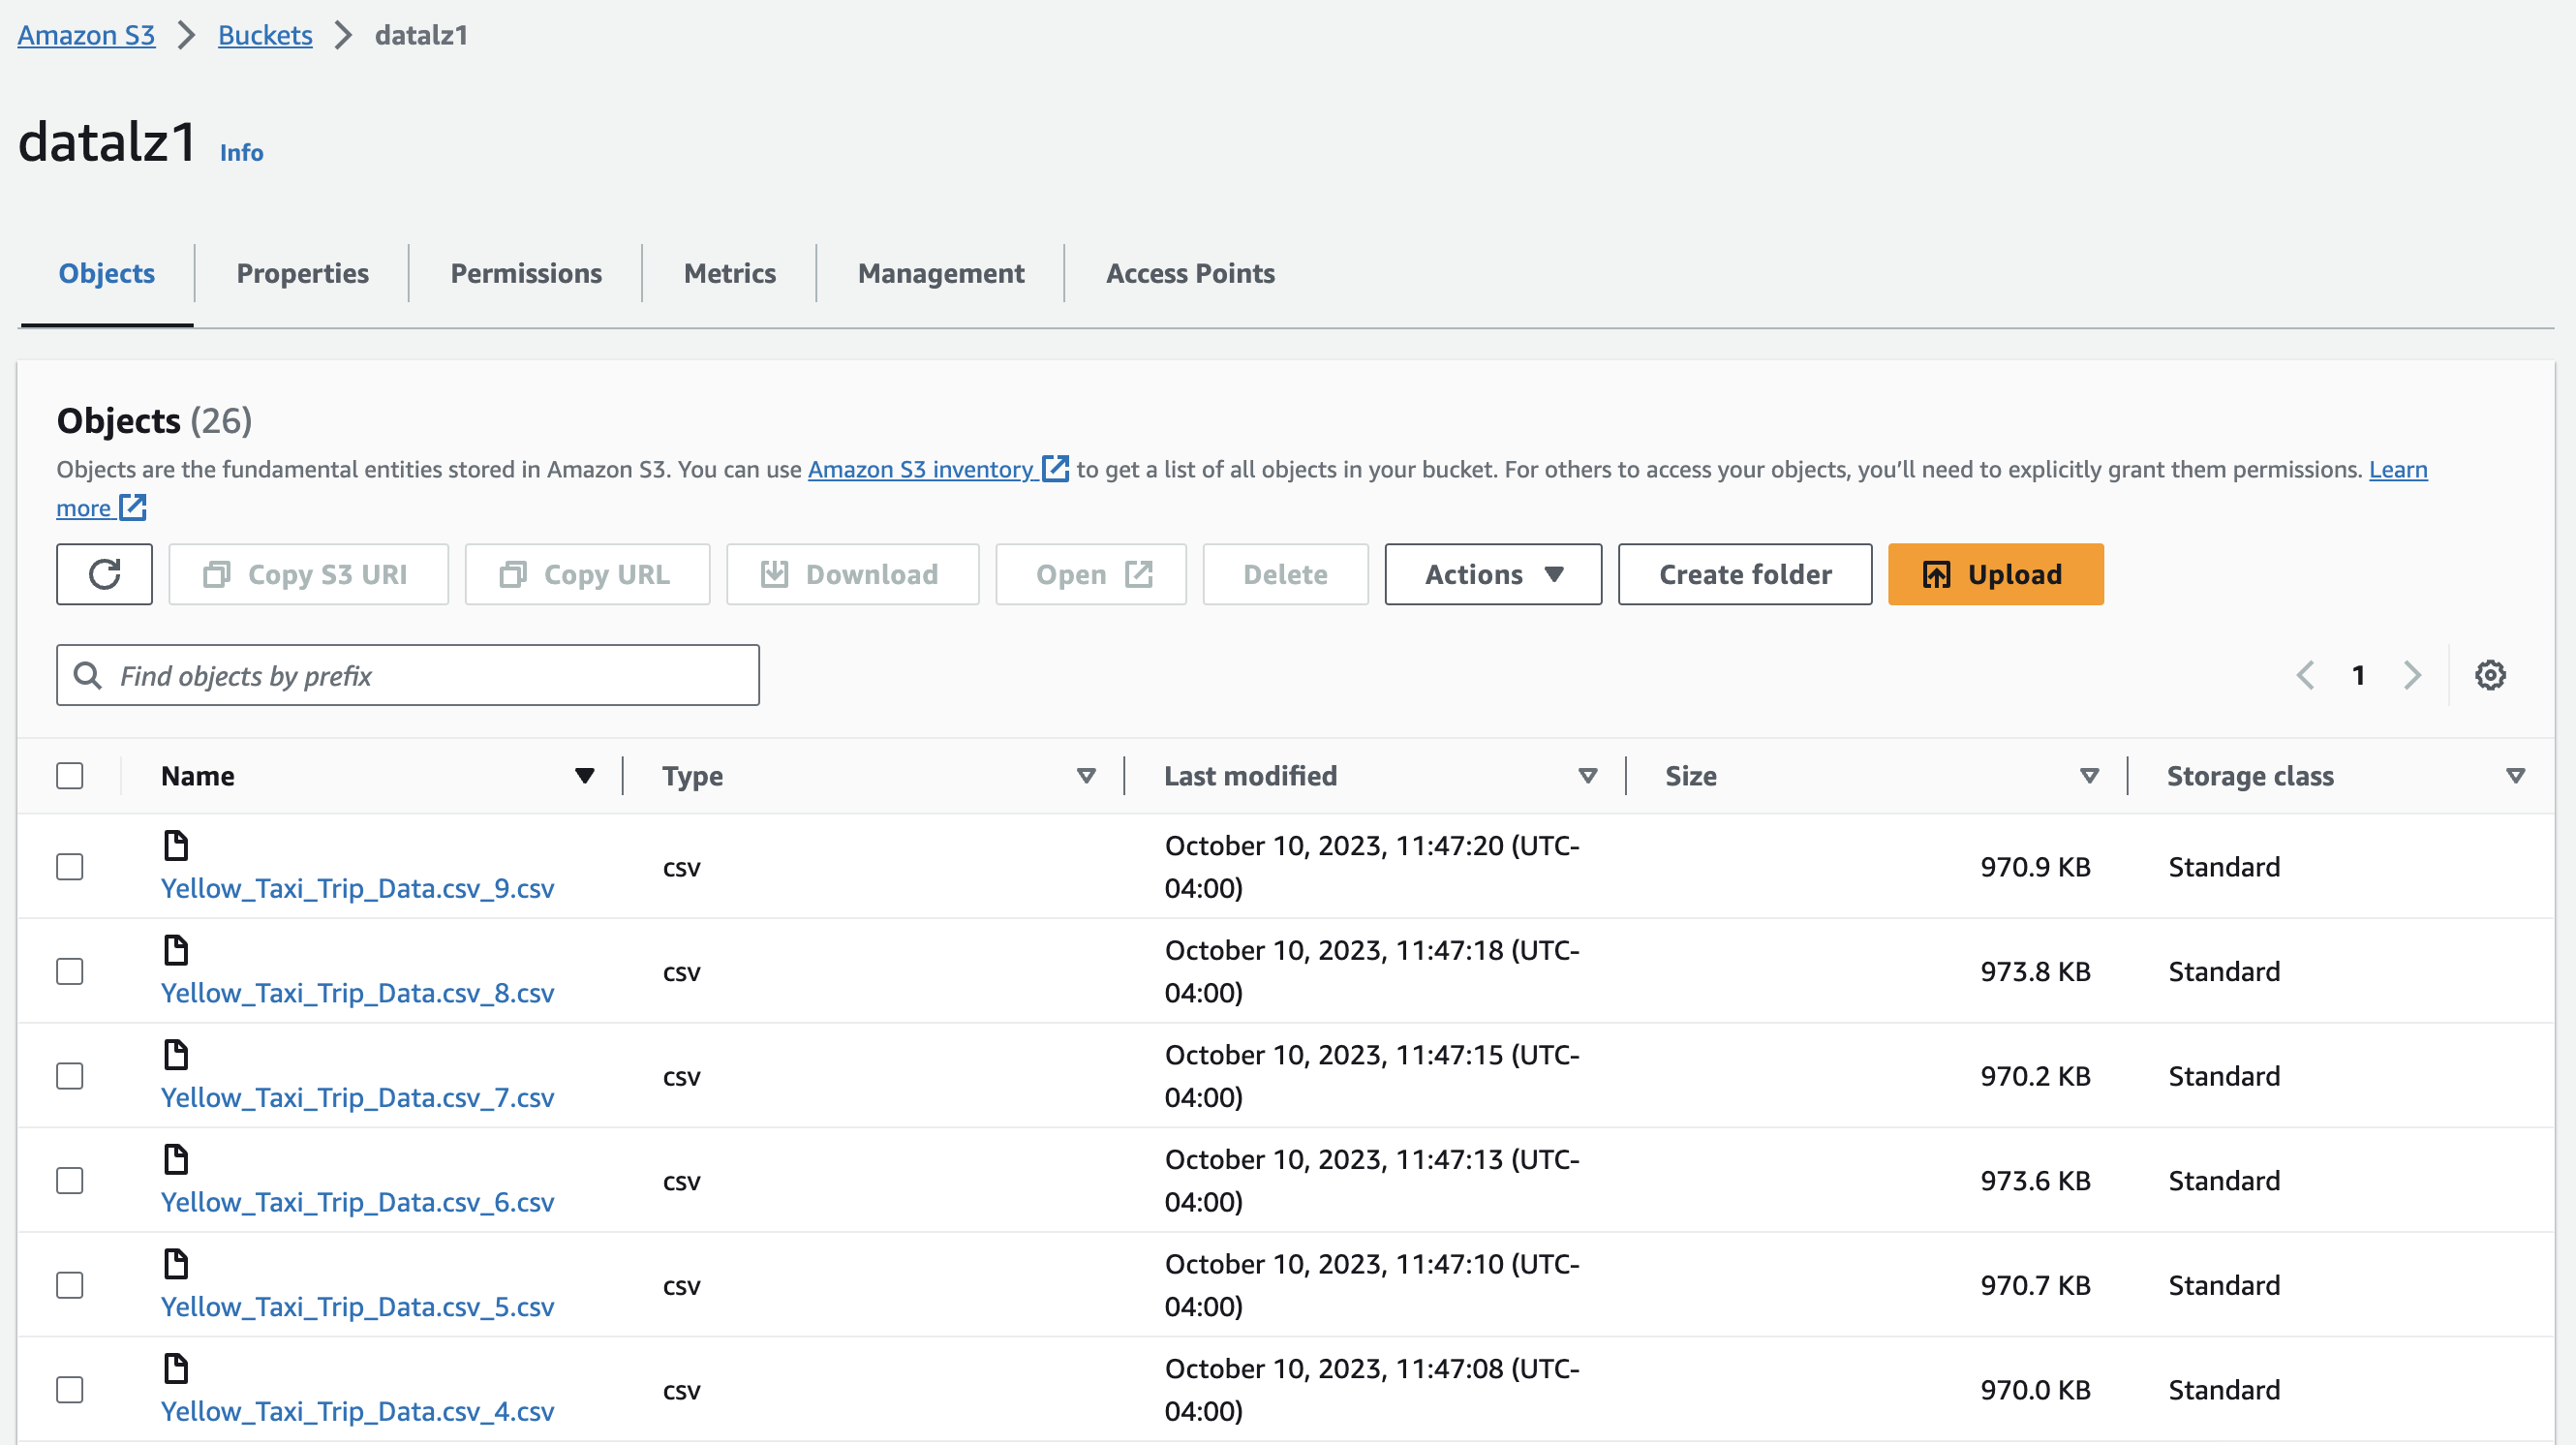

-----------

### 8.2 UDF to upload Small Dataset to S3 bucket 
#### Now we will be creating new UDF for uploading small dataset csv file to S3 

In [15]:
# UDF to upload Small-Dataset to S3 bucket 

def upload_to_aws(local_file, bucket, s3_file, profile_name):
    """
    Upload a local file to an S3 bucket.
    
    Args:
        local_file (str): The path to the local file to upload.
        bucket (str): The name of the S3 bucket.
        s3_file (str): The key to use for the uploaded file in the S3 bucket.
        profile_name (str): The name of the AWS profile to use for authentication.
    
    Returns:
        bool: True if the upload is successful, False otherwise.
    """
    # Create a session with the specified profile name
    session = boto3.Session(profile_name=profile_name)
    
    # Create an S3 client using the session
    s3 = session.client('s3')

    try:
        # Upload the local file to the S3 bucket with the specified key
        s3.upload_file(local_file, bucket, s3_file)
        
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False


In [16]:
# Using UDF uploaded to upload the data to s3 bucket using aws profile
uploaded = upload_to_aws('/Users/gagansingh/Documents/OneDrive/Documents/YU/InfoArch/M4_Assignment_Dataset_Profiling/taxi_zones.csv', \
                         'datalz1', 'taxi_zones.csv', 'datapro')

Upload Successful


### 9. UDF to Load Dataset from S3 bucket to Pandas dataframe 

In [12]:
## Load Dataset from S3 bucket to Pandas dataframe 

def load_s3_data(bucket, s3_file, profile_name, row_limit=None):
    """
    Load a CSV file from an S3 bucket into a Pandas dataframe.
    
    Args:
        bucket (str): The name of the S3 bucket.
        s3_file (str): The key of the CSV file in the S3 bucket.
        profile_name (str): The name of the AWS profile to use for authentication.
        row_limit (int, optional): The maximum number of rows to load. Defaults to None.
    
    Returns:
        pandas.DataFrame: The loaded data as a Pandas dataframe.
    """
    # Create a session with the specified profile name
    session = boto3.Session(profile_name=profile_name)
    
    # Create an S3 client using the session
    s3 = session.client('s3')

    try:
        # Get the object from the S3 bucket
        obj = s3.get_object(Bucket=bucket, Key=s3_file)
        
        # Read the CSV file from the object's body, limiting the number of rows if specified
        if row_limit is not None:
            data = pd.read_csv(obj['Body'], nrows=row_limit)
        else:
            data = pd.read_csv(obj['Body'])
        
        print("Data loading successful")
        return data
    except NoCredentialsError:
        print("Credentials not available")
        return None



In [14]:
# Use the function to load the data from the S3 bucket with row_limit for sample data
# dataframe = load_s3_data('datalz1', 'Yellow_Taxi_Trip_Data.csv.csv', 'your_profile_name', 10000)

# Use the function to load the data from the S3 bucket, full data
df_sample1 = load_s3_data('datalz1', 'Yellow_Taxi_Trip_Data.csv_21.csv', 'datapro')

df_sample1.head(10)

Data loading successful


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2021-01-06T17:49:24.000,2021-01-06T18:09:03.000,1,3.48,1,N,79,50,1,15.0,1.0,0.5,3.86,0.00,0.3,23.16,2.5
1,1,2021-01-06T17:04:18.000,2021-01-06T17:16:18.000,1,1.50,1,N,263,229,2,9.5,3.5,0.5,0.00,0.00,0.3,13.80,2.5
2,1,2021-01-06T17:19:46.000,2021-01-06T17:24:41.000,1,1.10,1,N,140,141,1,5.5,3.5,0.5,1.00,0.00,0.3,10.80,2.5
3,1,2021-01-06T17:31:01.000,2021-01-06T17:35:59.000,1,0.80,1,N,141,162,1,5.5,3.5,0.5,1.96,0.00,0.3,11.76,2.5
4,2,2021-01-06T17:18:27.000,2021-01-06T18:06:05.000,1,18.88,2,N,132,239,1,52.0,4.5,0.5,11.96,0.00,0.3,71.76,2.5
5,2,2021-01-06T17:26:33.000,2021-01-06T18:05:55.000,2,18.81,2,N,132,163,1,52.0,4.5,0.5,16.48,6.12,0.3,82.40,2.5
6,2,2021-01-06T16:58:56.000,2021-01-06T17:01:39.000,1,0.77,1,N,100,163,2,4.5,1.0,0.5,0.00,0.00,0.3,8.80,2.5
7,1,2021-01-06T17:23:29.000,2021-01-06T17:33:18.000,0,1.60,1,N,162,186,1,8.5,3.5,0.5,2.55,0.00,0.3,15.35,2.5
8,1,2021-01-06T17:37:02.000,2021-01-06T17:41:34.000,0,0.90,1,N,186,68,1,5.5,3.5,0.5,1.95,0.00,0.3,11.75,2.5
9,1,2021-01-06T17:44:26.000,2021-01-06T18:01:52.000,0,4.20,1,N,68,238,1,16.5,3.5,0.5,3.00,0.00,0.3,23.80,2.5


---------------

##### We will be doing DataProfling on total 30M rows and not on sample dataset to better understanding of the all over dataset an its consistency. 

In [2]:

# Specify the path to the local CSV file
csv_file_path = '/Users/gagansingh/Downloads/2021_Yellow_Taxi_Trip_Data.csv'

# Read the CSV file into a DataFrame
#data_sample = pd.read_csv(csv_file_path,nrows =100000)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path,)

## 10. Dataset Profiling

### Df head

In [25]:
# Eyeballing data
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,01/01/2021 12:30:10 AM,01/01/2021 12:36:12 AM,1.0,2.10,1.0,N,142,43,2.0,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
1,1.0,01/01/2021 12:51:20 AM,01/01/2021 12:52:19 AM,1.0,0.20,1.0,N,238,151,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1.0,01/01/2021 12:43:30 AM,01/01/2021 01:11:06 AM,1.0,14.70,1.0,N,132,165,1.0,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
3,1.0,01/01/2021 12:15:48 AM,01/01/2021 12:31:01 AM,0.0,10.60,1.0,N,138,132,1.0,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
4,2.0,01/01/2021 12:31:49 AM,01/01/2021 12:48:21 AM,1.0,4.94,1.0,N,68,33,1.0,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5


### Df Info

In [19]:
# summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30904072 entries, 0 to 30904071
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 4.1+ GB


### Df Shape

In [20]:
# Shape of the data frame df
df.shape

(30904072, 18)

## Determine the category of each column in a DataFrame.

In [13]:
def get_var_category(series):
    """
    Determine the category of a given series (column) in a DataFrame.
    
    Parameters:
        series (pandas.Series): The series to determine the category of.
        
    Returns:
        str: The category of the series.
    """
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    
    # Check if the series is numeric
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    
    # Check if the series is a datetime type
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    
    # Check if all values in the series are unique
    elif unique_count == total_count:
        return 'Text (Unique)'
    
    # If none of the above conditions are met, consider the series as categorical
    else:
        return 'Categorical'

def print_categories(df):
    """
    Print the category of each column in a DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to print the categories of.
    """
    for column_name in df.columns:
        # Print the column name and its corresponding category
        print(column_name, ": ", get_var_category(df[column_name]))

In [24]:
# Calling UDF print_categories to get category of each column
print_categories(df)

VendorID :  Numerical
tpep_pickup_datetime :  Categorical
tpep_dropoff_datetime :  Categorical
passenger_count :  Numerical
trip_distance :  Numerical
RatecodeID :  Numerical
store_and_fwd_flag :  Categorical
PULocationID :  Numerical
DOLocationID :  Numerical
payment_type :  Numerical
fare_amount :  Numerical
extra :  Numerical
mta_tax :  Numerical
tip_amount :  Numerical
tolls_amount :  Numerical
improvement_surcharge :  Numerical
total_amount :  Numerical
congestion_surcharge :  Numerical


### Statistical summary 

In [21]:
# Statistical summary 
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,3.007004e+07,2.942538e+07,3.090407e+07,2.942538e+07,3.090407e+07,3.090407e+07,3.007004e+07,3.090407e+07,3.090407e+07,3.090407e+07,3.090407e+07,3.090407e+07,3.090407e+07,3.090407e+07,3.025940e+07
mean,1.699227e+00,1.427478e+00,6.922726e+00,1.088625e+00,1.649317e+02,1.623440e+02,1.222708e+00,1.351937e+01,1.047732e+00,4.922739e-01,2.341167e+00,3.908641e-01,2.971687e-01,1.969634e+01,2.253087e+00
std,4.885247e-01,1.033372e+00,6.983826e+02,1.969074e+00,6.639557e+01,7.081091e+01,5.003988e-01,1.789894e+02,1.254697e+00,7.801513e-02,2.829037e+00,1.811449e+00,4.064982e-02,1.791949e+02,7.765825e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-7.580000e+02,-5.500000e+00,-5.500000e-01,-3.333200e+02,-8.875000e+01,-3.000000e-01,-9.510000e+02,-2.500000e+00
25%,1.000000e+00,1.000000e+00,1.100000e+00,1.000000e+00,1.300000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.176000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.810000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.530000e+01,2.500000e+00
75%,2.000000e+00,1.000000e+00,3.300000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.500000e+01,2.500000e+00,5.000000e-01,3.050000e+00,0.000000e+00,3.000000e-01,2.130000e+01,2.500000e+00
max,6.000000e+00,1.120000e+02,3.516134e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.182834e+05,9.006000e+01,3.880000e+01,1.140440e+03,9.565500e+02,3.000000e-01,8.182867e+05,3.000000e+00


### Finding Null Rate

In [22]:
# finding Null Rate
df.isna().mean().round(4).to_frame()

,0
VendorID,0.0270
tpep_pickup_datetime,0.0000
tpep_dropoff_datetime,0.0000
passenger_count,0.0478
trip_distance,0.0000
RatecodeID,0.0478
store_and_fwd_flag,0.0478
PULocationID,0.0000
DOLocationID,0.0000
payment_type,0.0270


## Categorical num unique values and most populous value for categorical

### For categorical values those we will find 2 statics
 1. the number of unique values
 2. the modal value - the value that occurs the most number of times

In [23]:
# Create an empty list to hold the records
stats = []

# Loop through non-numerical columns
for column_name in df.select_dtypes(exclude=['int64', 'float64']).columns:
    # Create an empty list to hold the record for each column
    record = []
    
    # Append the column name to the record
    record.append(column_name)
    
    # Append the number of unique values in the column to the record
    record.append(df[column_name].nunique())
    
    # Append the modal value in the column to the record
    record.append(df[column_name].value_counts().index[0])
    
    # Append the count of the modal value in the column to the record
    record.append(df[column_name].value_counts()[0])
    
    # Add the record to the larger stats array
    stats.append(record)
    
# Define the column names for the stats DataFrame
columns = ['Column Name', 'Number of Unique Values', 'Most Populous Column', 'Count']

# Create a DataFrame from the stats list using the specified column names
stats_df_full = pd.DataFrame(data=stats, columns=columns)

,Column Name,number of unique values,most popululous column,count
0,tpep_pickup_datetime,16906064,09/15/2021 05:22:00 PM,28
1,tpep_dropoff_datetime,16893686,12/08/2021 12:00:00 AM,39
2,store_and_fwd_flag,2,N,29005410


## Numeric mean and std deviation

For Numeric values we will find the mean and standard deviation.

In [26]:
# Create an empty list to hold the records
numerical = []

# Loop through numerical columns
for column_name in df.select_dtypes(include=['int64', 'float64']).columns:
    # Create an empty list to hold the record for each column
    record = []
    
    # Append the column name to the record
    record.append(column_name)
    
    # Append the mean of the column to the record
    record.append(df[column_name].mean())
    
    # Append the standard deviation of the column to the record
    record.append(df[column_name].std())
    
    # Add the record to the larger numerical array
    numerical.append(record)
    
# Define the column names for the numerical DataFrame
columns = ['Column Name', 'Mean', 'Standard Deviation']

# Create a DataFrame from the numerical list using the specified column names
numerical_df_full = pd.DataFrame(data=numerical, columns=columns)

,Column Name,mean,std_div
0,VendorID,1.699227,0.488525
1,passenger_count,1.427478,1.033372
2,trip_distance,6.922726,698.382618
3,RatecodeID,1.088625,1.969074
4,PULocationID,164.931713,66.395568
5,DOLocationID,162.343978,70.810914
6,payment_type,1.222708,0.500399
7,fare_amount,13.519366,178.989361
8,extra,1.047732,1.254697
9,mta_tax,0.492274,0.078015


### Numerical Columns Visualisation

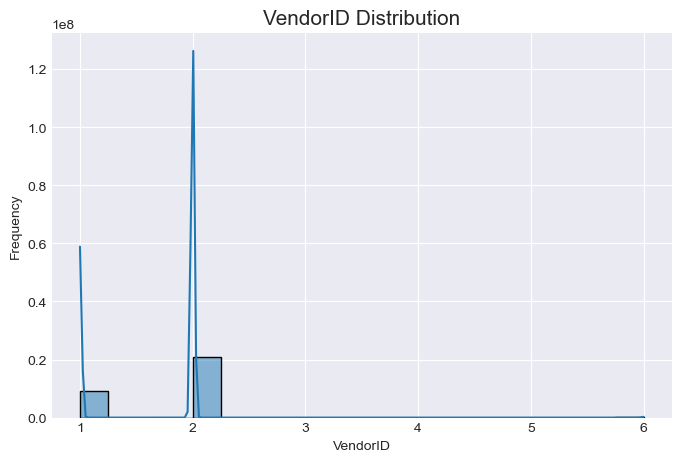

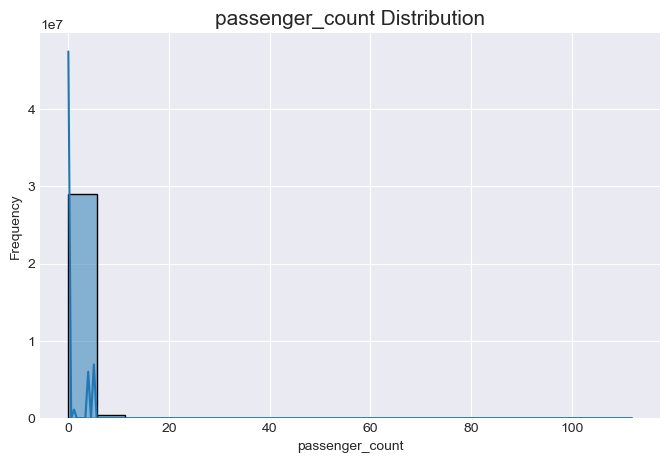

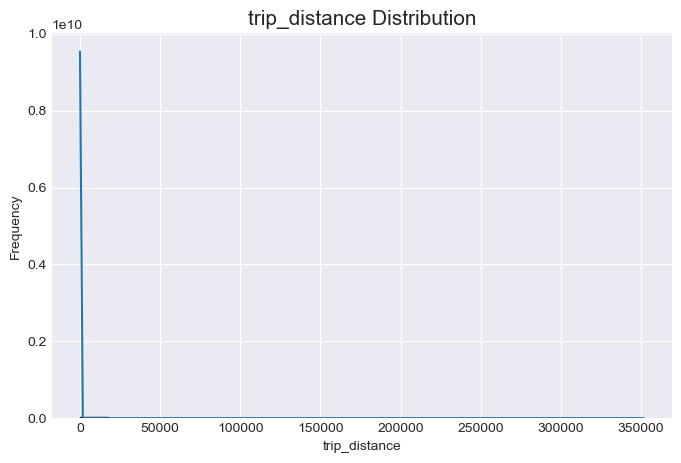

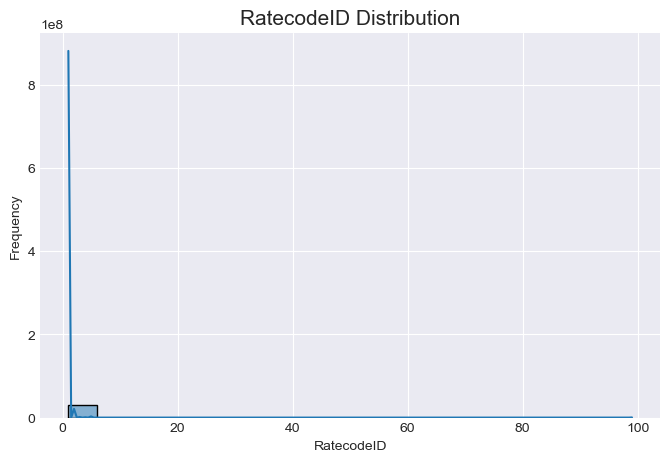

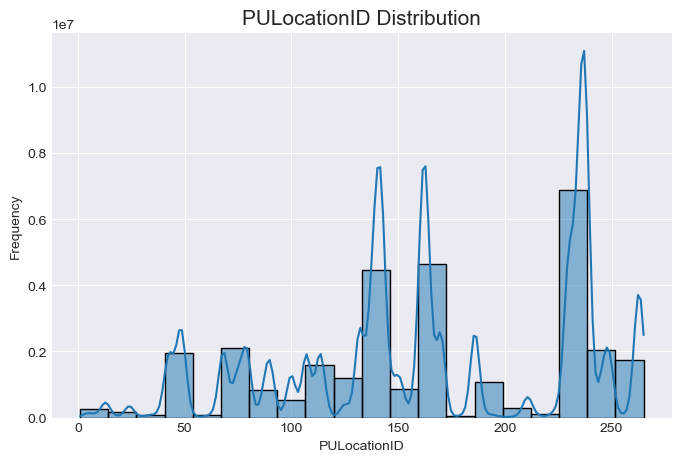

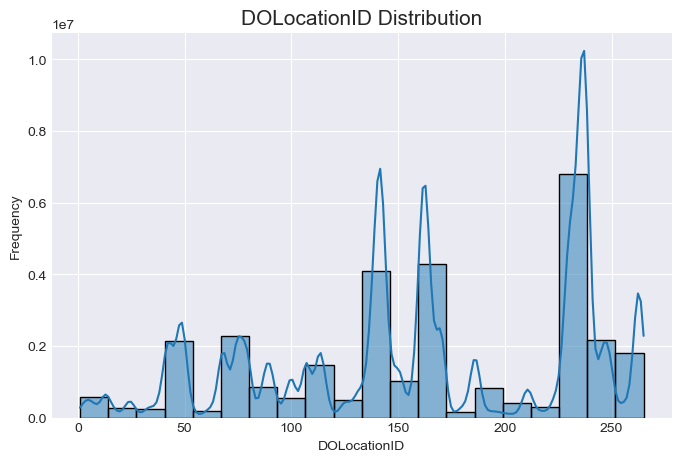

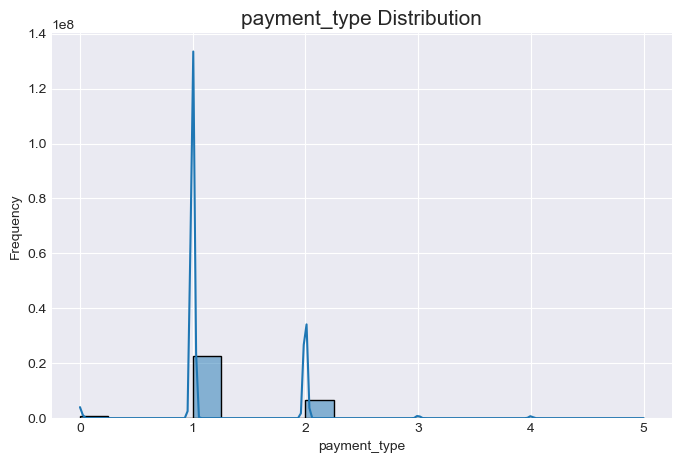

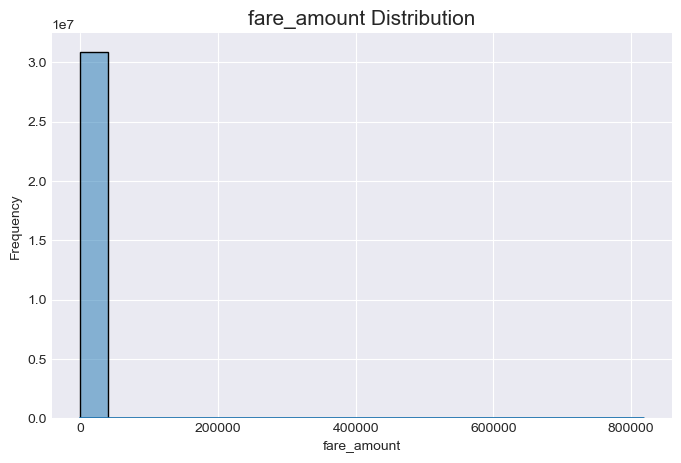

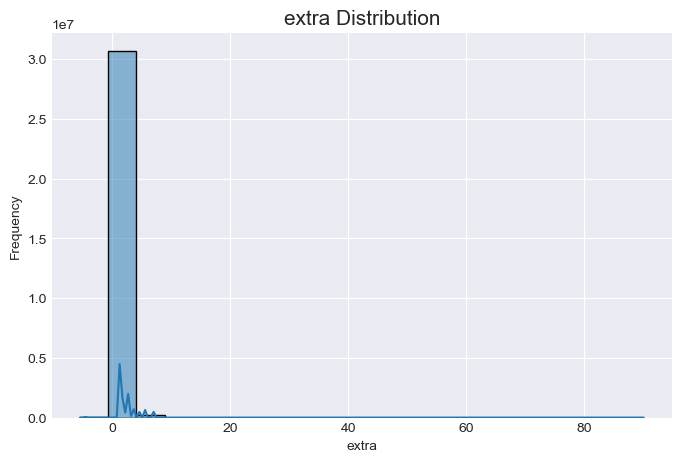

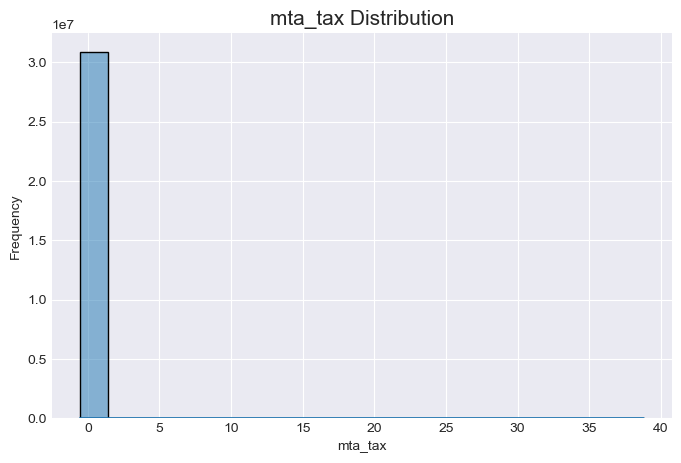

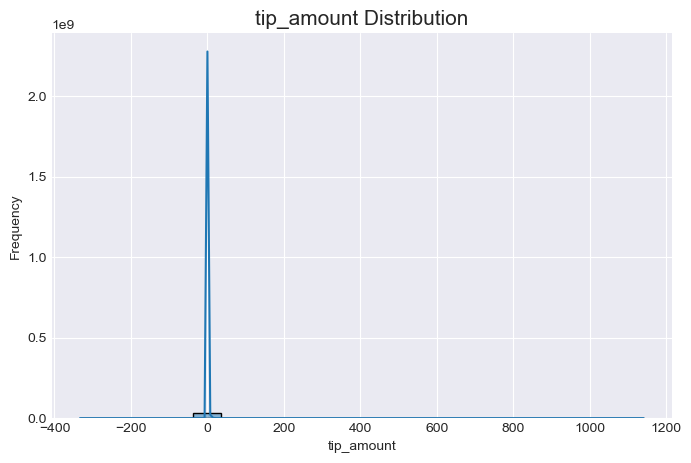

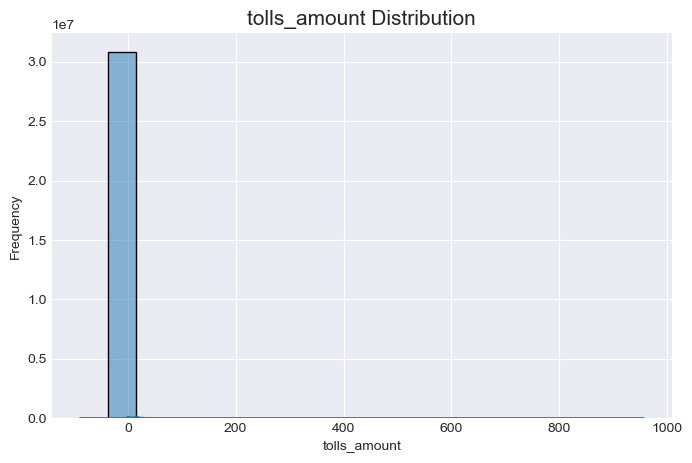

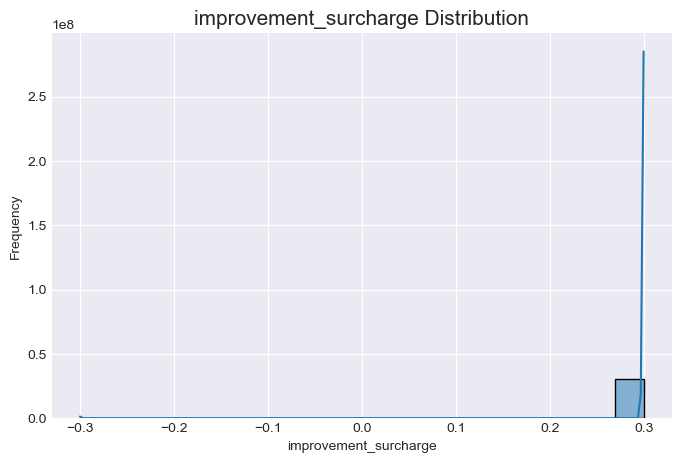

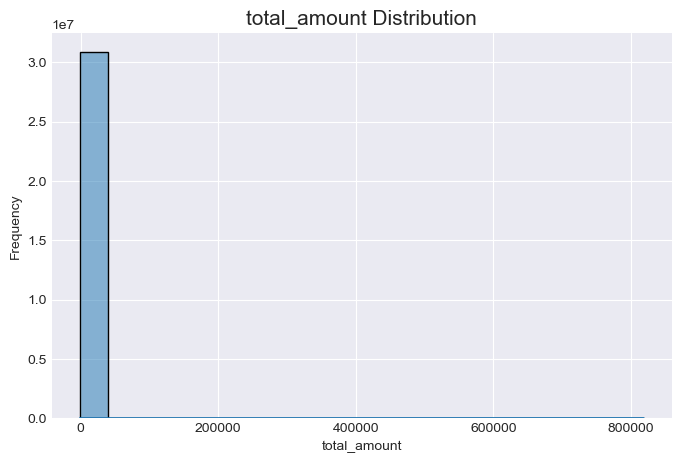

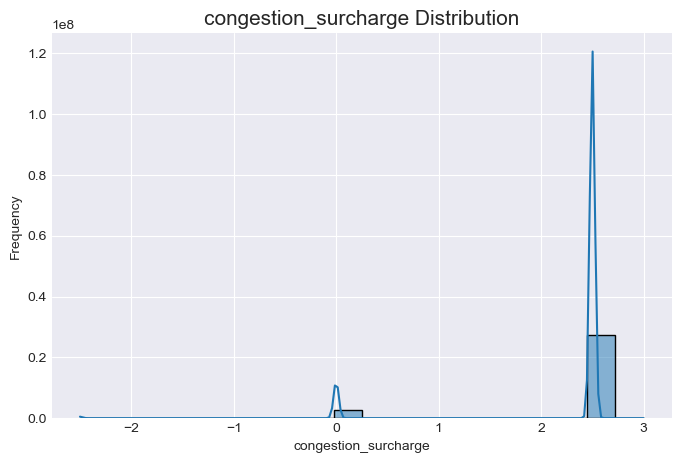

In [33]:
# Loop through numerical columns
for column_name in df.select_dtypes(include=['int64', 'float64']).columns:
    # Create subplots with 1 column and a figure size of 8x5
    fig, axs = plt.subplots(ncols=1, figsize=(8, 5))
    
    # Plot the histogram using seaborn
    sns.histplot(data=df, x=column_name, bins=20, ax=axs, kde=True)
    
    # Set the title, x-label, and y-label
    axs.set_title(f'{column_name} Distribution', fontsize=15)
    axs.set_xlabel(column_name)
    axs.set_ylabel('Frequency')
    
    # Show the plot
    plt.show()

### Categorical Columns Visualisation

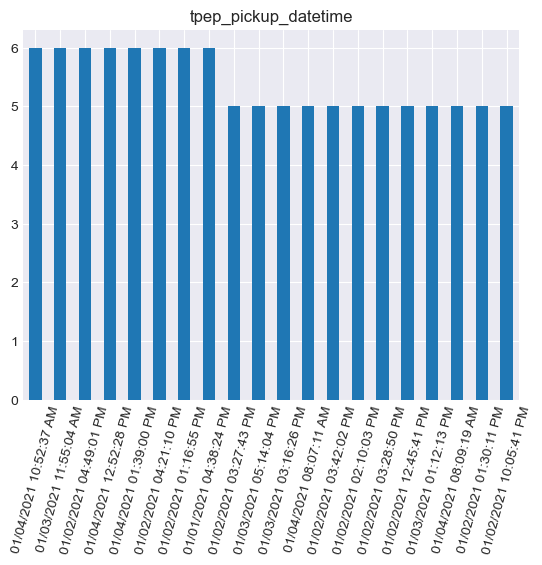

<Figure size 640x480 with 0 Axes>

In [42]:
# Visualization for the categorical variable 'tpep_pickup_datetime'
top_complaint_types = data_sample['tpep_pickup_datetime'].value_counts().head(20)
top_complaint_types.plot(kind='bar', title='tpep_pickup_datetime')
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.show()  # Display the plot
plt.savefig('complaint_types.png')  # Save the plot as a png file
plt.clf()  # Clear the current figure for the new plot

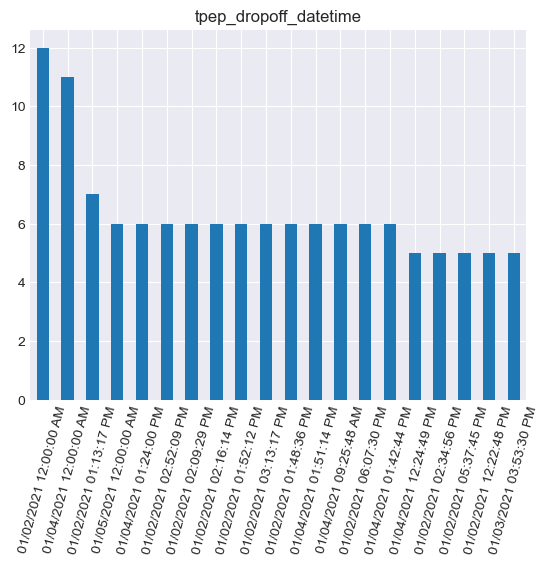

<Figure size 640x480 with 0 Axes>

In [43]:
# Visualization for the categorical variable 'tpep_dropoff_datetime'
top_complaint_types = data_sample['tpep_dropoff_datetime'].value_counts().head(20)
top_complaint_types.plot(kind='bar', title='tpep_dropoff_datetime')
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.show()  # Display the plot
plt.savefig('complaint_types.png')  # Save the plot as a png file
plt.clf()  # Clear the current figure for the new plot

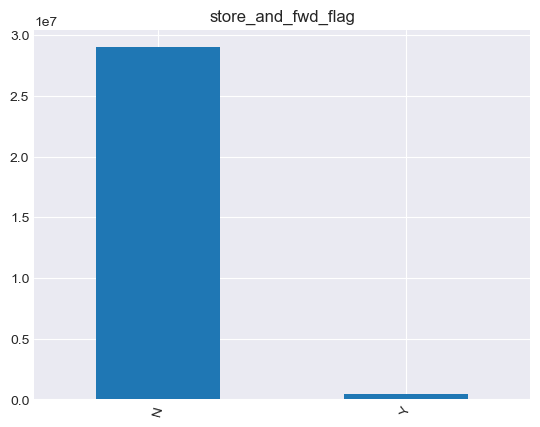

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualization for the categorical variable 'store_and_fwd_flag'
top_complaint_types = df['store_and_fwd_flag'].value_counts().head(20)
top_complaint_types.plot(kind='bar', title='store_and_fwd_flag')
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.show()  # Display the plot
plt.savefig('complaint_types.png')  # Save the plot as a png file
plt.clf()  # Clear the current figure for the new plot

## 11. Performing data profiling using pandas_profiling library

In [3]:
# Perform data profiling using pandas_profiling library
profile = pandas_profiling.ProfileReport(df, minimal=True)

# Save the report as an HTML file
profile.to_file("Yellow_Taxi_Trip_Data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 12. Import dataset into RDS

In [6]:

# Defining profile name
profile_name = 'datapro'

# Defining S3 bucket and file details
bucket_name = 'datalz1'
file_key = 'Yellow_Taxi_Trip_Data.csv_1.csv'

# Defining RDS MySQL details

# using json file to get the credentials of MySql
with open('/Users/gagansingh/Documents/OneDrive/Documents/YU/InfoArch/M4_Assignment_Dataset_Profiling/aws_rds_creds.json') as f:
    credentials = json.load(f)
mysql_username = credentials['MYSQL_USERNAME']
mysql_password = credentials['MYSQL_PASSWORD']

# Defining RDS Hostname, Port and Schema
mysql_host = 'database-1.cabnnjliqhn5.us-east-1.rds.amazonaws.com'
mysql_port = '3306'
mysql_database = 'TaxiStaging'

# Creating a session using your profile
session = boto3.Session(profile_name=profile_name)
s3 = session.resource('s3')

# Loading the data from S3
s3_file = s3.Object(bucket_name, file_key)

# Reading the CSV file directly into a pandas DataFrame
data = pd.read_csv(s3_file.get()["Body"])

# Creating the db engine
engine = create_engine(f'mysql+pymysql://{mysql_username}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_database}')

# Use to_sql() method to write to an SQL table
data.to_sql('TaxiDataStaging', con=engine, index=False, if_exists='replace')  # updated table name

10000

-----------------

Screen Shot:

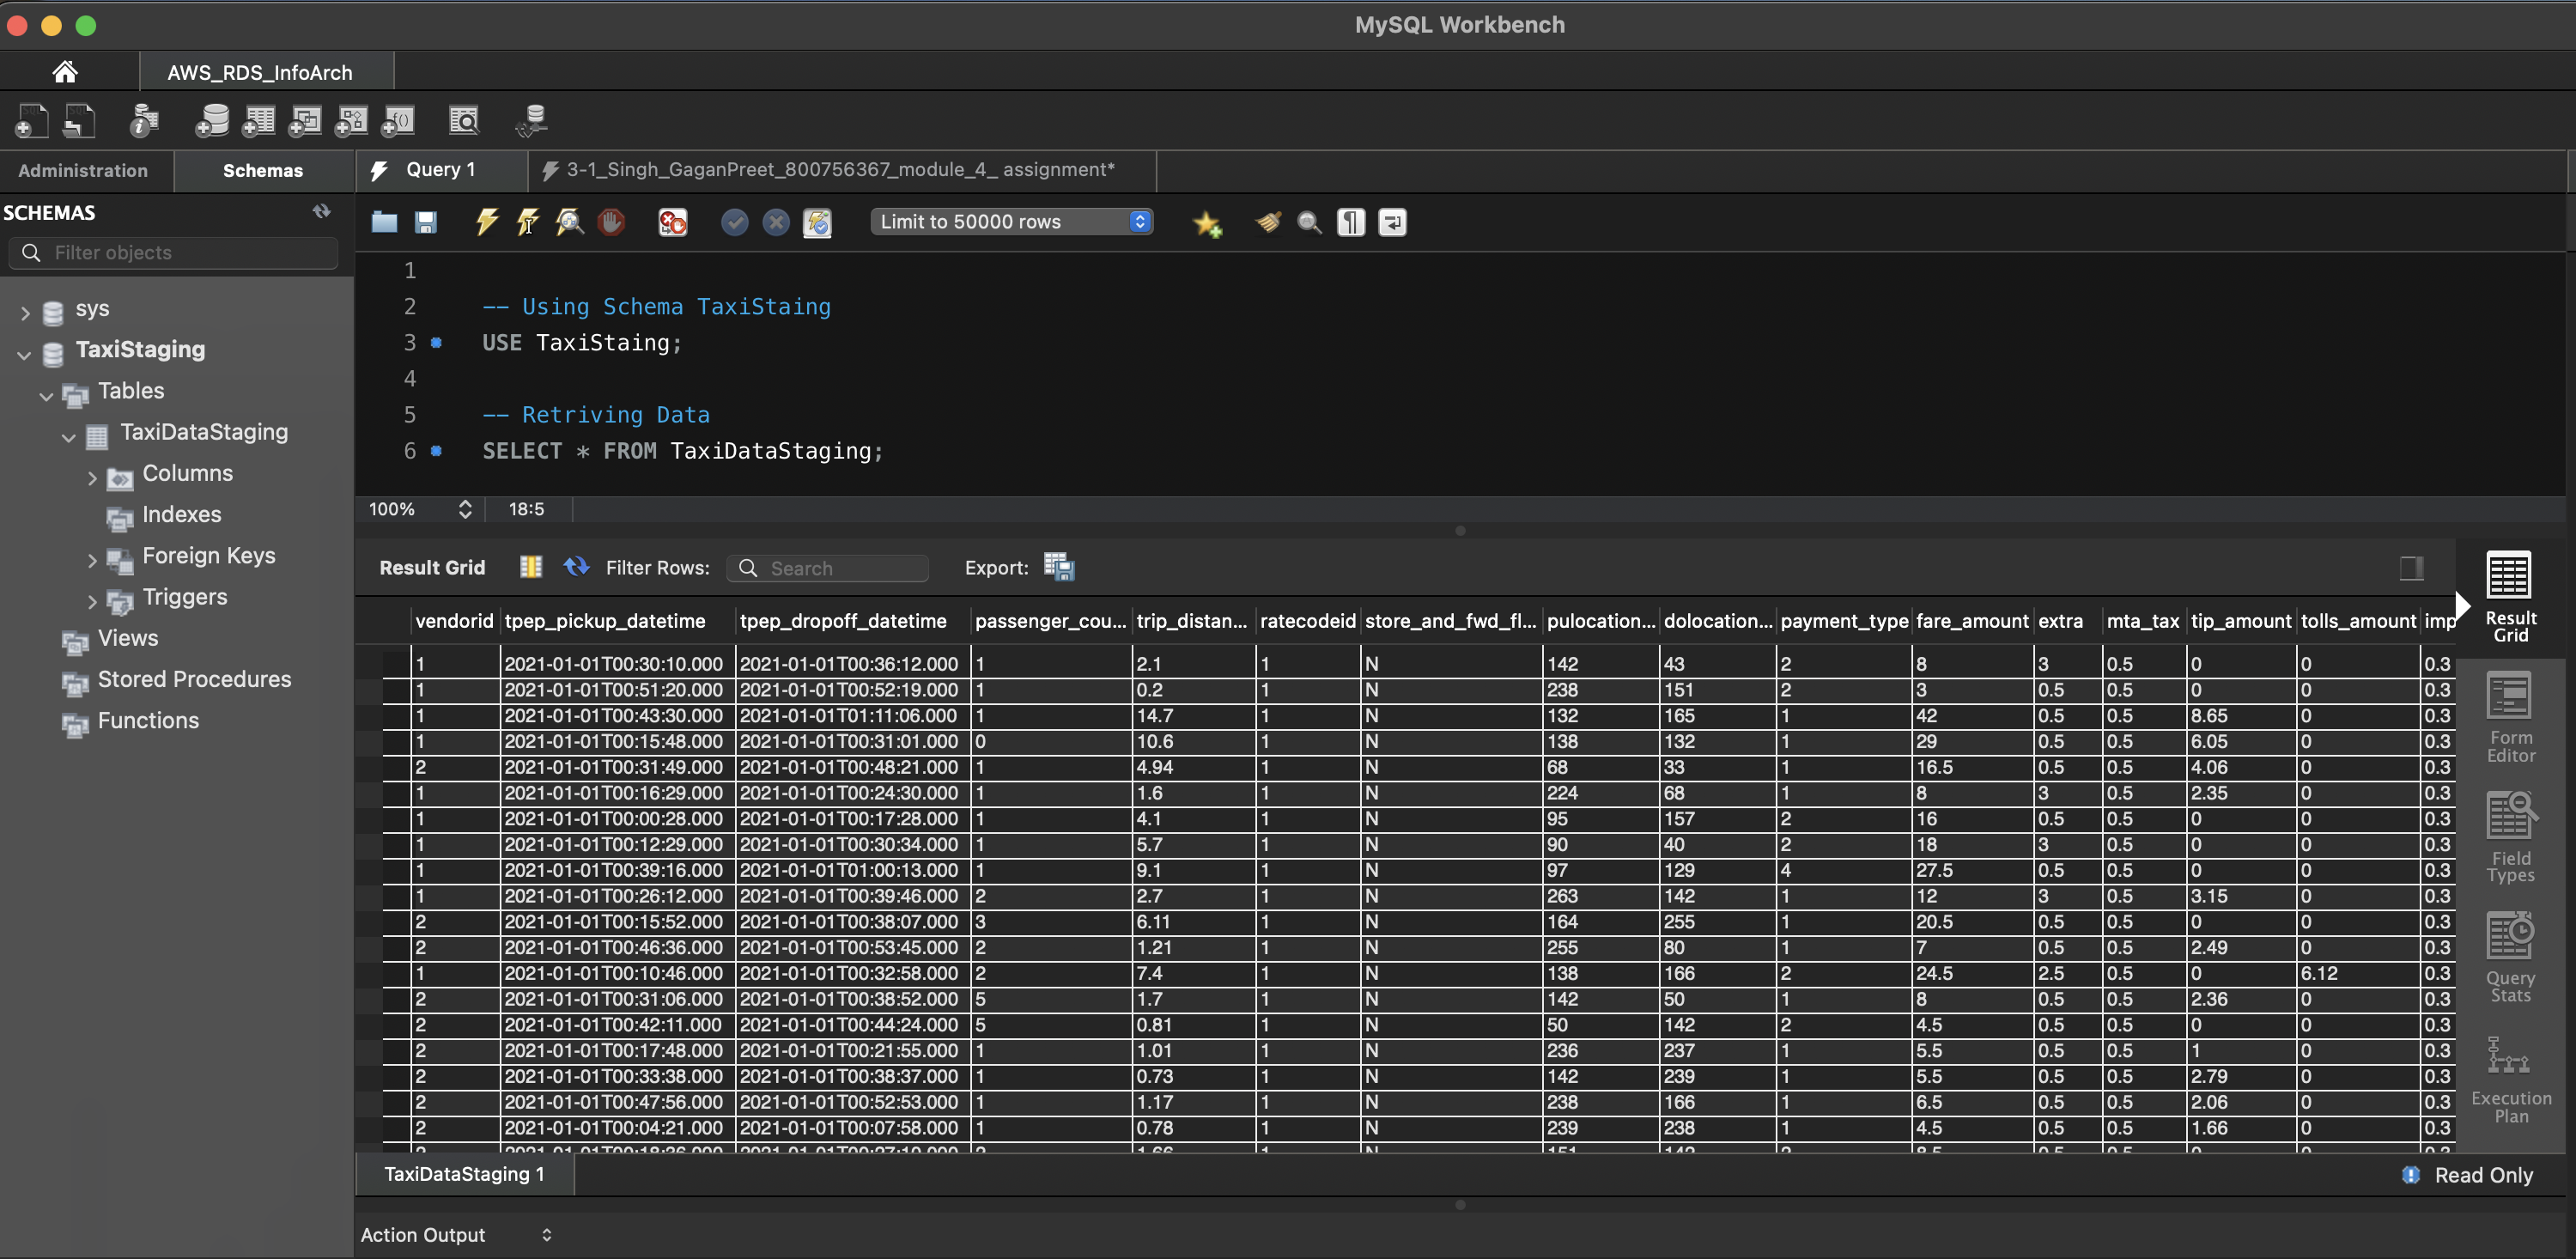



In [9]:
## Retriving Data from AWS_RDS 

# specifying SQL query
sql_query = "SELECT * FROM TaxiDataStaging LIMIT 10"

# executing the query and assign the result to a pandas DataFrame
df_rds = pd.read_sql_query(sql_query, engine)

# print the DataFrame
df_rds

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2021-01-01T00:30:10.000,2021-01-01T00:36:12.000,1,2.10,1,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
1,1,2021-01-01T00:51:20.000,2021-01-01T00:52:19.000,1,0.20,1,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1,2021-01-01T00:43:30.000,2021-01-01T01:11:06.000,1,14.70,1,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
3,1,2021-01-01T00:15:48.000,2021-01-01T00:31:01.000,0,10.60,1,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
4,2,2021-01-01T00:31:49.000,2021-01-01T00:48:21.000,1,4.94,1,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5
5,1,2021-01-01T00:16:29.000,2021-01-01T00:24:30.000,1,1.60,1,N,224,68,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5
6,1,2021-01-01T00:00:28.000,2021-01-01T00:17:28.000,1,4.10,1,N,95,157,2,16.0,0.5,0.5,0.00,0.0,0.3,17.30,0.0
7,1,2021-01-01T00:12:29.000,2021-01-01T00:30:34.000,1,5.70,1,N,90,40,2,18.0,3.0,0.5,0.00,0.0,0.3,21.80,2.5
8,1,2021-01-01T00:39:16.000,2021-01-01T01:00:13.000,1,9.10,1,N,97,129,4,27.5,0.5,0.5,0.00,0.0,0.3,28.80,0.0
9,1,2021-01-01T00:26:12.000,2021-01-01T00:39:46.000,2,2.70,1,N,263,142,1,12.0,3.0,0.5,3.15,0.0,0.3,18.95,2.5


=====================================================
===========================

=====================================================
===========